In [69]:
import urllib
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
import json
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

In [2]:
res = requests.get(f'https://www.google.com/search?q={urllib.parse.quote("요양원")}&sxsrf=AOaemvIg7vtIYt-lq_znIu_01EmjUVdDmQ:1636592131615&source=lnms&tbm=nws&sa=X&ved=2ahUKEwig-5XljI_0AhVhh1YBHZSxBzoQ_AUoA3oECAMQBQ&biw=1920&bih=937&dpr=1')
soup = BeautifulSoup(res.content, 'html.parser')
title = soup.select("div.QyR1Ze BA0A6c > span")
print(
for t in title :
    print(t.get_text())

SyntaxError: invalid syntax (Temp/ipykernel_12384/3403734041.py, line 5)

In [3]:
options = webdriver.ChromeOptions()
options.add_argument('headless')
options.add_argument('window-size=1920x1080')
driver = webdriver.Chrome('C:/Temp/chromedriver')

In [ ]:
print(urllib.parse.quote("요양원"))
driver.get(f'https://www.google.com/search?q={urllib.parse.quote("요양원")}&sxsrf=AOaemvIg7vtIYt-lq_znIu_01EmjUVdDmQ:1636592131615&source=lnms&tbm=nws&sa=X&ved=2ahUKEwig-5XljI_0AhVhh1YBHZSxBzoQ_AUoA3oECAMQBQ&biw=1920&bih=937&dpr=1')

In [ ]:
'#rso > div:nth-child(1) > g-card > div > div > a > div > div.iRPxbe >'
company, title, article = [],[],[]
#div_path = '#rso > div:nth-child(1) > g-card > div > div > a > div > div.iRPxbe >'
c_path = " div.QyR1Ze BA0A6c"
t_path = " div.mCBkyc.tNxQIb.ynAwRc.JIFdL.JQe2Ld.nDgy9d"
a_path = " div.GI74Re nDgy9d"

driver.get(f'https://www.google.com/search?q={urllib.parse.quote(word)}&tbm=nws&ei=rL2MYaKgGc76-Qa7tJTICw&start=0&sa=N&ved=2ahUKEwiipsDJ3I_0AhVOfd4KHTsaBbkQ8tMDegQIARA2&biw=1146&bih=887&dpr=1')
driver.implicitly_wait(3)
for i in range(1,11) :
    div_path = f'#rso > div:nth-child({i}) > g-card > div > div > a > div > div.iRPxbe >'
    company.append(driver.find_element_by_css_selector(div_path+c_path).text)
    title.append(driver.find_element_by_css_selector(div_path+t_path).text)
    article.append(driver.find_element_by_css_selector(div_path+a_path).text)

# 셀렉터 테스트 첫번째 페이지

In [18]:
driver = webdriver.Chrome('C:/Temp/chromedriver')

In [27]:
driver.get(f'https://www.google.com/search?q={urllib.parse.quote(word)}&tbm=nws&ei=rL2MYaKgGc76-Qa7tJTICw&start=0&sa=N&ved=2ahUKEwiipsDJ3I_0AhVOfd4KHTsaBbkQ8tMDegQIARA2&biw=1146&bih=887&dpr=1')
# cssSelector = "#rso div.iRPxbe"
# driver.find_element_by_css_selector(cssSelector).text

'뉴시스\n.\n서울확진자 다시 1000명대…노원 요양시설 집단감염(종합)\n.\n감염경로별로는 노원구 소재 요양시설 관련 확진자가 17명 신규 발생해 총 19명이 감염됐다. 해당 시설에서는 종사자 2명이 지난 9일 최초 확진된...\n.\n5시간 전'

In [30]:
dataList = []
for i in range(1, 11):
    cssSelector = f"#rso > div:nth-child({i}) > g-card > div > div > a > div > div.iRPxbe"
    dataList.append(driver.find_element_by_css_selector(cssSelector).text)

In [39]:
# "\n"으로 나누기
tempList = []
for data in dataList:
    temps = data.split('\n')
    for temp in temps:
        if temp != "." :
            tempList.append(temp)

In [43]:
company, title, article, date = [], [], [], []
# 언론사, 뉴스제목, 뉴스요약기사, 발행일 분리
for i, temp in enumerate(tempList):
    if i % 4 == 0 :
        company.append(temp)
    elif i % 4 == 1:
        title.append(temp)
    elif i % 4 == 2:
        article.append(temp)
    else:
        date.append(temp)

# 셀렉터 테스트 여러 페이지

In [ ]:
driver = webdriver.Chrome('C:/Temp/chromedriver')

In [49]:
startPage = 0
company, title, article, date = [], [], [], []
endPage = 100
while True:
    driver.get(f'https://www.google.com/search?q={urllib.parse.quote(word)}&tbm=nws&ei=rL2MYaKgGc76-Qa7tJTICw&start={startPage}&sa=N&ved=2ahUKEwiipsDJ3I_0AhVOfd4KHTsaBbkQ8tMDegQIARA2&biw=1146&bih=887&dpr=1')
    dataList = []
    for i in range(1, 11):
        cssSelector = f"#rso > div:nth-child({i}) > g-card > div > div > a > div > div.iRPxbe"
        dataList.append(driver.find_element_by_css_selector(cssSelector).text)
    # "\n"으로 나누기
    tempList = []
    for data in dataList:
        temps = data.split('\n')
        for temp in temps:
            if temp != "." :
                tempList.append(temp)
    # 언론사, 뉴스제목, 뉴스요약기사, 발행일 분리
    for i, temp in enumerate(tempList):
        if i % 4 == 0 :
            company.append(temp)
        elif i % 4 == 1:
            title.append(temp)
        elif i % 4 == 2:
            article.append(temp)
        else:
            date.append(temp)
    # 반복문 끝
    if endPage == startPage:
        break
    startPage += 10

In [61]:
# 데이터 프레임 만들기
data = pd.DataFrame({'company' : company, 'title' : title, 'article' : article, 'date' : date})

In [63]:
# 데이터 프레임 저장하기
# data/nver_crawl/검색년도-검색월-검색일_keywore_goole.csv로 저장하기
searchDate = time.strftime('%Y-%m-%d', time.localtime(time.time()))
data.to_csv("google_crawl/" + searchDate + "_goole.csv", index=False)

In [53]:
# 확인하기
print(len(date), date)

110 ['5시간 전', '2일 전', '2일 전', '2일 전', '1주 전', '1일 전', '1일 전', '23시간 전', '1일 전', '1일 전', '1일 전', '2일 전', '1일 전', '2일 전', '2일 전', '1주 전', '3시간 전', '3시간 전', '3일 전', '6일 전', '1일 전', '1일 전', '1일 전', '20시간 전', '1주 전', '3일 전', '2주 전', '2일 전', '2주 전', '1시간 전', '6일 전', '4주 전', '6일 전', '1주 전', '1시간 전', '1시간 전', '2일 전', '6일 전', '7시간 전', '3주 전', '5시간 전', '4일 전', '1일 전', '6시간 전', '3일 전', '3주 전', '2주 전', '1일 전', '1주 전', '3일 전', '3주 전', '1주 전', '9시간 전', '1일 전', '2주 전', '1주 전', '1개월 전', '2주 전', '3주 전', '1일 전', '1일 전', '2일 전', '4주 전', '5일 전', '1일 전', '1일 전', '1주 전', '1일 전', '2주 전', '2021. 8. 9.', '2021. 8. 17.', '2021. 8. 30.', '2021. 6. 30.', '2021. 8. 20.', '1개월 전', '2021. 9. 13.', '2021. 9. 2.', '2021. 4. 30.', '1개월 전', '2021. 9. 8.', '2021. 8. 1.', '1개월 전', '2021. 2. 26.', '1개월 전', '2021. 8. 25.', '2021. 9. 12.', '2021. 8. 11.', '2021. 5. 31.', '2021. 4. 13.', '2021. 9. 16.', '1개월 전', '2021. 8. 7.', '2021. 5. 21.', '2021. 9. 1.', '1개월 전', '2021. 7. 13.', '1개월 전', '2021. 8. 10.', '2021. 9. 3.', '202

# 형태소분석

In [64]:
from konlpy.tag import Kkma
sample = '이것은 형태소 분석기 입니다 아버지가방에들어가신다'
kkma = Kkma()
print(kkma.nouns(sample))

['이것', '형태소', '분석기', '아버지', '아버지가방', '가방']


In [65]:
nounsList = []
kkma = Kkma()
for i in range(len(data)):
    nonusTemp = kkma.nouns(data.loc[i, "title"])
    nounsList.append(nonusTemp)
# 이중리스트 풀기
nounsList = [y for x in nounsList for y in x]
nounsString = ' '.join(nounsList)

# 워드 클라우드

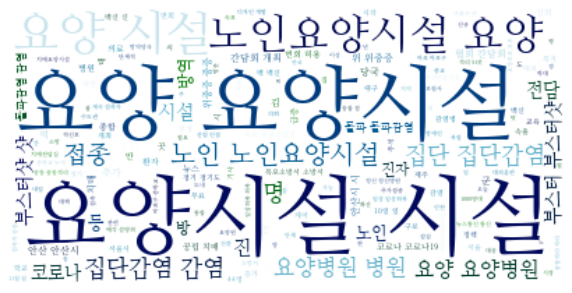

In [71]:
# myfontpath = "./data/font/NanumMyeongjo.ttf" 
myfontpath = "font/NanumMyeongjo.ttf"
plt.figure(figsize=(10,6))
wc = WordCloud(font_path = myfontpath, background_color="white", 
               contour_width=5, contour_color="royalblue",
               colormap = 'ocean')
wc.generate(nounsString)
wc.to_file('../output/goole_wordcloud.png')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# 빈도수 만들기

# 함수 만들기

# 여러 검색어를 찾아옵니다.

In [ ]:
keyword = ['요양원', '요양시설']
company, title, article = [],[],[]
div_path = '//*[@id="rso"]/div[1]/g-card/div/div/a/div/div[2]'
//*[@id="rso"]/div[2]/g-card/div/div/a/div/div
for word in keyword :
    num=0
    while True :
        url = f'https://www.google.com/search?q={urllib.parse.quote(word)}&tbm=nws&ei=rL2MYaKgGc76-Qa7tJTICw&start='+str(num)+'&sa=N&ved=2ahUKEwiipsDJ3I_0AhVOfd4KHTsaBbkQ8tMDegQIARA2&biw=1146&bih=887&dpr=1'
        print(url)
        driver.get(url)      
        driver.implicitly_wait(3)
        #byXPath = driver.find_element_by_xpath('//*[@id="rso"]')
        try :
            for i in range(1,11) :
                print(i)
                company.append(driver.find_element_by_xpath(div_path+str(i)+c_path).text)
                title.append(driver.find_element_by_xpath(div_path+str(i)+t_path).text)
                article.append(driver.find_element_by_xpath(div_path+str(i)+a_path).text)            
        except Exception as e:
            print(e)
            break
        num = num+10
            
        print('정상종료')

# 버려진 코드

In [14]:
keyword = ['요양원', '요양시설']
company, title, article = [],[],[]
div_path = '//*[@id="rso"]/div['
c_path = "]/g-card/div/div/a/div/div/span"
t_path = "]/g-card/div/div/a/div/div[2]/div[2]"
a_path = "]/g-card/div/div/a/div/div[2]/div[3]"
for word in keyword :
    num=0
    while True :
        url = f'https://www.google.com/search?q={urllib.parse.quote(word)}&tbm=nws&ei=rL2MYaKgGc76-Qa7tJTICw&start='+str(num)+'&sa=N&ved=2ahUKEwiipsDJ3I_0AhVOfd4KHTsaBbkQ8tMDegQIARA2&biw=1146&bih=887&dpr=1'
        print(url)
        driver.get(url)      
        driver.implicitly_wait(3)
        #byXPath = driver.find_element_by_xpath('//*[@id="rso"]')
        try :
            for i in range(1,11) :
                print(i)
                company.append(driver.find_element_by_xpath(div_path+str(i)+c_path).text)
                title.append(driver.find_element_by_xpath(div_path+str(i)+t_path).text)
                article.append(driver.find_element_by_xpath(div_path+str(i)+a_path).text)            
        except Exception as e:
            print(e)
            break
        num = num+10
            
        print('정상종료')

In [ ]:
print(company)
print(title)

In [ ]:
driver.quit()